# **Regression with XGB, LightGBM, and CatBoost**
 Hpyerparameters are tuned with cross-validation and bayesian optimization


In [19]:
pip install catboost

In [20]:
pip install bayesian-optimization

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import reciprocal, norm

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from numpy.random import seed

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from bayes_opt import BayesianOptimization
import pickle

In [22]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [23]:
cols=['GAMMA','RHO','DTCO']
#X = data[cols]
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [24]:
seed(42)
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [25]:
X_train = X_train0[cols]
X_test = X_test0[cols]

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562, 3) (135562, 1)
(15063, 3) (15063, 1)


In [26]:
scaler_x = preprocessing.StandardScaler().fit(X_train)
X_train_sc = pd.DataFrame(scaler_x.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc = pd.DataFrame(scaler_x.transform(X_test), columns=X_test.columns, index=X_test.index)

In [27]:
def mape(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  return np.mean(np.abs(y_test-y_pred)/y_test)

def print_scores(y, pred, text):
  print('%s: MSE: %.2f, RMSE: %.2f, R^2 Score: %.2f, MAPE: %.4f' % (text, mean_squared_error(y, pred),np.sqrt(mean_squared_error(y, pred)),r2_score(y, pred), mape(y, pred)))

## XGB model

In [28]:
xgb_dtrain = xgb.DMatrix(data = X_train_sc, label = Y_train)
xgb_dtest = xgb.DMatrix(data = X_test_sc, label = Y_test)


In [29]:
# Define R-Sqaured
def xgb_r2(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2', -r2_score(preds, labels)
  
def obj_xgb(booster, max_depth, eta, gamma, min_child_weight, subsample, 
            colsample_bytree, reg_lambda, rate_drop):
    
  boosters = ['gbtree', 'dart']
  params = {
     # 'booster': 'gbtree',  # default
     # 'objective': 'reg:squarederror', # default
  }
  params['max_depth'] = int(round(max_depth))
  params['eta'] = max(min(eta, 1), 0)
  params['gamma'] = max(gamma, 0)
  params['min_child_weight'] = int(min_child_weight)
  params['subsample'] = max(min(subsample, 1), 0)
  params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
  params['lambda'] = max(reg_lambda, 0)
  params['booster'] = boosters[int(round(booster))]
  params['rate_drop'] = max(min(rate_drop, 1), 0)

  scores = xgb.cv(params, 
                  xgb_dtrain, 
                  num_boost_round=100,
                  verbose_eval=False, 
                  early_stopping_rounds=5,
                  #feval=xgb_r2,
                  maximize=False,   # True causes issue with feval 
                  nfold=3)
  
  return  -scores['test-rmse-mean'].iloc[-1]  # for maximization

In [30]:
boosters = ['gbtree', 'dart']
pds_xgb ={
  'booster':(0, 1),
  'max_depth': (2, 10),
  'eta': (0, 0.9),      #learning_rate
  'gamma': (0, 9),      #min_split_loss
  'min_child_weight': (10, 20),
  'subsample': (0.1, 1),
  'colsample_bytree': (0.1, 1),
  'reg_lambda': (0, 1),
  'rate_drop' : (0, 0.9)
}

optimizer_xgb = BayesianOptimization(obj_xgb, pds_xgb, random_state=42)

optimizer_xgb.maximize(init_points=10, n_iter=20)

|   iter    |  target   |  booster  | colsam... |    eta    |   gamma   | max_depth | min_ch... | rate_drop | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -11.06    |  0.3745   |  0.9556   |  0.6588   |  5.388    |  3.248    |  11.56    |  0.05228  |  0.8662   |  0.641    |
|  2        | -14.8     |  0.7081   |  0.1185   |  0.8729   |  7.492    |  3.699    |  11.82    |  0.1651   |  0.3042   |  0.5723   |
|  3        | -11.58    |  0.4319   |  0.3621   |  0.5507   |  1.255    |  4.337    |  13.66    |  0.4105   |  0.7852   |  0.2797   |
|  4        | -131.1    |  0.5142   |  0.6332   |  0.04181  |  5.468    |  3.364    |  10.65    |  0.854    |  0.9656   |  0.8276   |
|  5        | -11.49    |  0.3046   |  0.1879   |  0.6158   |  3.961    |  2.976    |  14.95    |  0.03095  |  0.9093   |  0.3329   |
|  6        | -81.47    |  0.6625   |  0.3805   |  0.4681   | 

In [31]:
op_xgb = optimizer_xgb.max['params']

print("opt booster:",boosters[int(round(op_xgb['booster']))])
op_xgb

opt booster: gbtree


{'booster': 0.43032825305813865,
 'colsample_bytree': 0.9635568028868563,
 'eta': 0.16405273067727505,
 'gamma': 8.404380366262854,
 'max_depth': 5.53026088072577,
 'min_child_weight': 12.57416667206492,
 'rate_drop': 0.5509043763702806,
 'reg_lambda': 0.40891608797413864,
 'subsample': 0.45308653537944565}

In [32]:
params_xgb = {
    'booster': 'gbtree', 
    'colsample_bytree': 1,
    'eta': 0.2,
    'gamma': 8,
    'max_depth': 6,
    'min_child_weight': 13,
    'reg_lambda': 0.4,
    'subsample': 0.5,
 #   'rate_drop': 0.6
}


watchlist = [(xgb_dtest, 'eval'), (xgb_dtrain, 'train')]
num_round = 100

start = datetime.now()   
model_xgb = xgb.train(params_xgb, 
                      xgb_dtrain, 
                      num_round,
                      watchlist,
                      early_stopping_rounds=5, 
                      )
         
exe_time_xgb = datetime.now() - start   # supposed to be faster than sklearn wrapper

print("XGB execution time: ", exe_time_xgb)

[0]	eval-rmse:109.004	train-rmse:109.101
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 5 rounds.
[1]	eval-rmse:87.4637	train-rmse:87.5448
[2]	eval-rmse:70.2834	train-rmse:70.3616
[3]	eval-rmse:56.6226	train-rmse:56.6847
[4]	eval-rmse:45.782	train-rmse:45.8335
[5]	eval-rmse:37.2044	train-rmse:37.253
[6]	eval-rmse:30.4704	train-rmse:30.5141
[7]	eval-rmse:25.2284	train-rmse:25.2707
[8]	eval-rmse:21.2013	train-rmse:21.2341
[9]	eval-rmse:18.1497	train-rmse:18.1783
[10]	eval-rmse:15.8935	train-rmse:15.9099
[11]	eval-rmse:14.2575	train-rmse:14.2638
[12]	eval-rmse:13.1007	train-rmse:13.0951
[13]	eval-rmse:12.2872	train-rmse:12.2713
[14]	eval-rmse:11.7491	train-rmse:11.7157
[15]	eval-rmse:11.3823	train-rmse:11.3408
[16]	eval-rmse:11.152	train-rmse:11.096
[17]	eval-rmse:10.9968	train-rmse:10.9323
[18]	eval-rmse:10.891	train-rmse:10.8155
[19]	eval-rmse:10.8257	train-rmse:10.7411
[20]	eval-rmse:10.7801	train-rm

In [33]:
pred_xgb = model_xgb.predict(xgb_dtest)
print_scores(Y_test.DTSM, pred_xgb, 'XGB')

XGB: MSE: 113.36, RMSE: 10.65, R^2 Score: 0.91, MAPE: 0.0521


In [34]:
with open('model_xgb.pkl', 'wb') as fout:
  pickle.dump(model_xgb, fout)

## Light GBM

In [35]:
lgb_dtrain = lgb.Dataset(X_train_sc, label=Y_train)
lgb_dtest = lgb.Dataset(X_test_sc, label=Y_test)

In [36]:
def lgb_r2_score(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2', r2_score(labels, preds), True


# Objective Function
def obj_lgb(boosting, learning_rate, num_leaves, min_data_in_leaf, max_depth, 
             min_split_gain, lambda_l2, drop_rate):
  boostings = ['gbdt', 'dart']
  params = {
        'objective':'regression', # default
  }
  params['boosting'] = boostings[int(round(boosting))]
  params['learning_rate'] = max(learning_rate, 0)    
  params["num_leaves"] = int(round(num_leaves))
  params['max_depth'] = int(round(max_depth))
  params['min_data_in_leaf'] = int(round(min_data_in_leaf))
  params['min_split_gain'] = max(min_split_gain, 0)
  params['lambda_l2'] = max(lambda_l2, 0)
  params['drop_rate'] = max(min(drop_rate, 1), 0)

  cv_results = lgb.cv(params, 
                      lgb_dtrain, 
                      num_boost_round=100,
                      #early_stopping_rounds=5,
                      nfold=3, 
                      seed=42,
                      categorical_feature=[], 
                      stratified=False
                      )
        
  return -np.min(cv_results['l2-mean'])

In [37]:
lgb_boostings = ['gbdt', 'dart']
pds_lgb = {
    'boosting': (0, 1),
    'learning_rate': (0.01, 1),
    'num_leaves': (10, 20),    # important
    'max_depth': (2, 10),       # important
    'min_data_in_leaf': (50, 200),  # important
    'min_split_gain': (0.001, 0.1),
    'lambda_l2': (0.01, 1),
    'drop_rate': (0.1, 1)
    }

optimizer_lgb = BayesianOptimization(obj_lgb, pds_lgb, random_state=42)
                                  
optimizer_lgb.maximize(init_points=5, n_iter=15)

|   iter    |  target   | boosting  | drop_rate | lambda_l2 | learni... | max_depth | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


|  1        | -117.3    |  0.3745   |  0.9556   |  0.7347   |  0.6027   |  3.248    |  73.4     |  0.00675  |  18.66    |
|  2        | -116.3    |  0.6011   |  0.7373   |  0.03038  |  0.9702   |  8.66     |  81.85    |  0.019    |  11.83    |
|  3        | -115.7    |  0.3042   |  0.5723   |  0.4376   |  0.2983   |  6.895    |  70.92    |  0.02992  |  13.66    |
|  4        | -116.3    |  0.4561   |  0.8067   |  0.2077   |  0.5191   |  6.739    |  56.97    |  0.06115  |  11.71    |
|  5        | -117.4    |  0.06505  |  0.954    |  0.966    |  0.8103   |  4.437    |  64.65    |  0.06874  |  14.4     |
|  6        | -117.0    |  0.8679   |  0.5093   |  0.5204   |  0.494    |  7.335    |  70.95    |  0.003967 |  13.08    |
|  7        | -302.7    |  0.5009   |  0.8857   |  0.9001   |  0.08883  |  8.663    |  129.9    |  0.06468  |  11.15    |
|  8        | -280.0    |  0.0      |  0.9758   |  0.01     |  0.01     |  6.366    |  76.39    |  0.1      |  14.63    |
|  9        | -117.8    

In [38]:
op_lgb = optimizer_lgb.max['params']

print(lgb_boostings[int(round(op_lgb['boosting']))])
op_lgb

gbdt


{'boosting': 0.29396500005654586,
 'drop_rate': 0.5780689477184782,
 'lambda_l2': 0.4299083778767871,
 'learning_rate': 0.29137756354454575,
 'max_depth': 6.887696025390187,
 'min_data_in_leaf': 71.0054251905124,
 'min_split_gain': 0.031187595786946076,
 'num_leaves': 13.679032176825332}

In [39]:
params_lgb = {
    'objective':'regression', # default
    'boosting': 'gbdt',
    'lambda_l2': 0.4,
    'learning_rate': 0.3,
    'max_depth': 7,    #important
    'min_data_in_leaf': 70,  #important
    'min_split_gain': 0.03,
    'num_leaves': 14,  #important
    #'drop_rate': 0.5
}

start = datetime.now()
model_lgb = lgb.train(params_lgb,
                      lgb_dtrain,
                      valid_sets=lgb_dtest,
                      num_boost_round=100,
                      categorical_feature=[],
                      early_stopping_rounds=5)
exe_time_lgb = datetime.now() - start

print("LightGBM execution time: ", exe_time_lgb)


[1]	valid_0's l2: 669.221
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 399.127
[3]	valid_0's l2: 262.45
[4]	valid_0's l2: 194.533
[5]	valid_0's l2: 160.096
[6]	valid_0's l2: 141.983
[7]	valid_0's l2: 132.54
[8]	valid_0's l2: 127.253
[9]	valid_0's l2: 123.921
[10]	valid_0's l2: 122.142
[11]	valid_0's l2: 120.476
[12]	valid_0's l2: 119.775
[13]	valid_0's l2: 119.201
[14]	valid_0's l2: 118.705
[15]	valid_0's l2: 118.343
[16]	valid_0's l2: 118.144
[17]	valid_0's l2: 117.946
[18]	valid_0's l2: 117.762
[19]	valid_0's l2: 117.675
[20]	valid_0's l2: 117.433
[21]	valid_0's l2: 117.236
[22]	valid_0's l2: 117.162
[23]	valid_0's l2: 117.041

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[24]	valid_0's l2: 116.899
[25]	valid_0's l2: 116.901
[26]	valid_0's l2: 116.77
[27]	valid_0's l2: 116.772
[28]	valid_0's l2: 116.637
[29]	valid_0's l2: 116.618
[30]	valid_0's l2: 116.547
[31]	valid_0's l2: 116.491
[32]	valid_0's l2: 116.25
[33]	valid_0's l2: 116.113
[34]	valid_0's l2: 116.077
[35]	valid_0's l2: 116.036
[36]	valid_0's l2: 115.947
[37]	valid_0's l2: 115.903
[38]	valid_0's l2: 115.717
[39]	valid_0's l2: 115.621
[40]	valid_0's l2: 115.581
[41]	valid_0's l2: 115.442
[42]	valid_0's l2: 115.378
[43]	valid_0's l2: 115.374
[44]	valid_0's l2: 115.301
[45]	valid_0's l2: 115.266
[46]	valid_0's l2: 115.169
[47]	valid_0's l2: 115.049
[48]	valid_0's l2: 114.961
[49]	valid_0's l2: 114.927
[50]	valid_0's l2: 114.806
[51]	valid_0's l2: 114.752
[52]	valid_0's l2: 114.746
[53]	valid_0's l2: 114.69
[54]	valid_0's l2: 114.668
[55]	valid_0's l2: 114.638
[56]	valid_0's l2: 114.605
[57]	valid_0's l2: 114.602
[58]	valid_0's l2: 114.591
[59]	valid_0's l2: 114.489
[60]	valid_0's l2: 114.471
[61

In [40]:
pred_lgb = model_lgb.predict(X_test_sc)
print_scores(Y_test.DTSM, pred_lgb, 'LightGBM')

LightGBM: MSE: 114.42, RMSE: 10.70, R^2 Score: 0.91, MAPE: 0.0528


In [41]:
with open('model_lgb.pkl', 'wb') as fout:
    pickle.dump(model_lgb, fout)

#with open('model_lgb.pkl', 'rb') as fin:
#    model2 = pickle.load(fin)

# model_lgb.save_model('model_lgb.txt')
# model2 = lgb.Booster(model_file='model_lgb.txt')


#model_json = model_lgb.dump_model()
#with open('model_lgb.json', 'w+') as f:
#    json.dump(model_json, f, indent=4)

## Catboost


In [42]:
cat_dtrain = cat.Pool(data=X_train_sc, label=Y_train, cat_features=[])
cat_dtest = cat.Pool(data=X_test_sc, label=Y_test, cat_features=[])

In [43]:
def obj_cat(learning_rate,depth, bagging_temperature, l2_leaf_reg, min_data_in_leaf):
    
  params = {
      'loss_function': 'RMSE',

  }

  params['learning_rate'] = max(learning_rate, 0)      
  params['depth'] = int(round(depth)) 
  params['bagging_temperature'] = max(bagging_temperature, 0)
  params['l2_leaf_reg'] = max(l2_leaf_reg, 0)  
  params['min_data_in_leaf'] = int(round(min_data_in_leaf))
  #params['max_leaves'] = int(round(max_leaves)) 
  
  scores = cat.cv(cat_dtrain,
                  params,
                  iterations=100,
                  early_stopping_rounds=5,
                  fold_count=3,
                  verbose=0)
  return -np.min(scores['test-RMSE-mean'])  

In [44]:
pds_cat = {
    'learning_rate': (0.01, 1),
    'depth': (2, 10),
    'bagging_temperature': (1, 10),   # Bayesian bootstrap to assign random weights to objects
    'l2_leaf_reg': (0.1, 10),
    'min_data_in_leaf': (50, 100),

}

optimizer_cat = BayesianOptimization(obj_cat, pds_cat, random_state=42)

optimizer_cat.maximize(init_points=5, n_iter=15)

|   iter    |  target   | baggin... |   depth   | l2_lea... | learni... | min_da... |
-------------------------------------------------------------------------------------
Stopped by overfitting detector  (5 iterations wait)
|  1        | -10.79    |  4.371    |  9.606    |  7.347    |  0.6027   |  57.8     |
|  2        | -11.05    |  2.404    |  2.465    |  8.675    |  0.6051   |  85.4     |
|  3        | -10.71    |  1.185    |  9.759    |  8.341    |  0.2202   |  59.09    |
|  4        | -10.87    |  2.651    |  4.434    |  5.295    |  0.4376   |  64.56    |
|  5        | -10.96    |  6.507    |  3.116    |  2.992    |  0.3727   |  72.8     |
|  6        | -51.33    |  1.0      |  10.0     |  0.1      |  0.01     |  100.0    |
|  7        | -10.75    |  3.387    |  7.987    |  6.788    |  0.4202   |  61.49    |
|  8        | -10.87    |  4.689    |  4.462    |  4.736    |  0.4074   |  69.19    |
Stopped by overfitting detector  (5 iterations wait)
|  9        | -10.77    |  2.086  

In [45]:
op_cat = optimizer_cat.max['params']
op_cat

{'bagging_temperature': 1.185260448662222,
 'depth': 9.759278817295954,
 'l2_leaf_reg': 8.341182143924176,
 'learning_rate': 0.2202157195714934,
 'min_data_in_leaf': 59.09124836035503}

In [46]:
params_cat = {
    'iterations': 100,
    'loss_function': 'RMSE',
    'bagging_temperature': 1.2,
    'depth': 10,
    'l2_leaf_reg': 8,
    'learning_rate': 0.2,
    'min_data_in_leaf': 60
}

model_cat = cat.CatBoostRegressor(**params_cat)

start = datetime.now()
model_cat.fit(cat_dtrain,
              early_stopping_rounds=5)

exe_time_cat = datetime.now() - start

print("CatBoost execution time: ", exe_time_cat)

0:	learn: 29.0323590	total: 39.5ms	remaining: 3.92s
1:	learn: 24.3622969	total: 75.9ms	remaining: 3.72s
2:	learn: 20.7419923	total: 112ms	remaining: 3.62s
3:	learn: 18.0044787	total: 153ms	remaining: 3.67s
4:	learn: 15.9546361	total: 192ms	remaining: 3.64s
5:	learn: 14.4814034	total: 233ms	remaining: 3.66s
6:	learn: 13.4102071	total: 275ms	remaining: 3.66s
7:	learn: 12.6777935	total: 311ms	remaining: 3.57s
8:	learn: 12.1525779	total: 347ms	remaining: 3.51s
9:	learn: 11.7861030	total: 392ms	remaining: 3.53s
10:	learn: 11.5329644	total: 429ms	remaining: 3.47s
11:	learn: 11.3570249	total: 465ms	remaining: 3.41s
12:	learn: 11.2336041	total: 508ms	remaining: 3.4s
13:	learn: 11.1461875	total: 551ms	remaining: 3.39s
14:	learn: 11.0806328	total: 587ms	remaining: 3.33s
15:	learn: 11.0315202	total: 626ms	remaining: 3.29s
16:	learn: 10.9940891	total: 661ms	remaining: 3.23s
17:	learn: 10.9676940	total: 695ms	remaining: 3.17s
18:	learn: 10.9451510	total: 733ms	remaining: 3.13s
19:	learn: 10.9200660

In [47]:
cat_feat_imp = model_cat.get_feature_importance(cat_dtrain)
df_cat_feat_imp = pd.DataFrame({'feature_names': X_train.columns, 'feature_importance': cat_feat_imp})
df_cat_feat_imp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
df_cat_feat_imp

,feature_names,feature_importance
2,DTCO,76.019746
0,GAMMA,12.306571
1,RHO,11.673682


In [48]:
pred_cat = model_cat.predict(cat_dtest)
print_scores(Y_test.DTSM, pred_cat, 'CatBoost')

CatBoost: MSE: 112.50, RMSE: 10.61, R^2 Score: 0.91, MAPE: 0.0521


In [49]:
model_cat.save_model('model_cat',
                     format="json",
                     export_parameters=None,
                     pool=None)

## Results


In [50]:
obser = Y_test.DTSM

titles = ['XGB', 'LightGBM', 'CatBoost']
preds = [pred_xgb, pred_lgb, pred_cat]
resids = [obser - p for p in preds]
ets = [str(et) for et in [exe_time_xgb, exe_time_lgb, exe_time_cat]]

test_mse = [mean_squared_error(obser, pred) for pred in preds]
test_rmse = np.sqrt(test_mse)
test_r2 = [r2_score(obser, pred) for pred in preds]
test_mape = [mape(obser, pred) for pred in preds]

results_metrics = pd.DataFrame({'Model': titles,
                                'Exeurtion_time':ets, 
                                'MSE': test_mse, 
                                'RMSE': test_rmse, 
                                'R2_score': test_r2, 
                                'MAPE': test_mape})
results_metrics.head()

,Model,Exeurtion_time,MSE,RMSE,R2_score,MAPE
0,XGB,0:00:11.452540,113.359781,10.647055,0.906490,0.052133
1,LightGBM,0:00:00.468995,114.424126,10.696921,0.905612,0.052815
2,CatBoost,0:00:04.128593,112.502162,10.606704,0.907198,0.052140


In [58]:
def lowess_sm(obser, pred, sample_size):
  idx = np.random.choice(np.arange(len(pred)), sample_size, replace=False)
  pred_sample = pred[idx]
  obser_sample = obser.to_numpy()[idx]
  resid_sample = pred_sample - obser_sample
  pred_sort, obser_sort,resid_sort = zip(*sorted(zip(pred_sample, obser_sample, resid_sample)))
 
  resid_sm = lowess(resid_sort,pred_sort, frac=0.4)[:,1]
  obser_sm = lowess(obser_sort,pred_sort, frac=0.4)[:,1]

  return pred_sort, obser_sm, resid_sm


def cm_wh(cmp_name):
  cmp = cm.get_cmap(cmp_name, 256)
  newcm = cmp(np.linspace(0, 1, 256))
  newcm[0, :] = np.array([1, 1, 1, 1])
  return ListedColormap(newcm)


def plot_resid_pred(pred, obser, resid, pred_osrt, obser_sm, resid_sm, fig, ax, title):

  ax1, ax2, ax3 = ax 
  h1=ax1.hist2d(pred, obser,bins=100, cmap=cm_wh('jet'))
  ax1.plot(pred_sort, obser_sm, color='red', label='smoothed')
  #ax1.axline([0, 0], [1, 1], color='white')
  ax1.set_xlabel("Predicted")
  ax1.set_ylabel("Observe")
  ax1.set_xlim(70,240)
  ax1.set_ylim(70,240)
  ax1.set_xticks(np.arange(80,240,20))
  ax1.set_yticks(np.arange(80,240,20))
  ax1.grid()
  ax1.legend()
  ax1.set_title(title, loc='left')
  h1[3].set_clim(0,110)
  fig.colorbar(h1[3], ax=ax1)

  h2=ax2.hist2d(pred, resid,bins=100, cmap=cm_wh('jet'))
  ax2.plot(pred_sort, resid_sm, color='red', label='smoothed')
  ax2.set_xlabel("Predicted")
  ax2.set_ylabel("Residual")
  ax2.set_xlim(75,240)
  ax2.set_ylim(-50,50)
  ax2.grid()
  ax2.legend()
  h2[3].set_clim(0,100)
  fig.colorbar(h2[3], ax=ax2)

  n, bins, patches = ax3.hist(resid, 60, density=True, facecolor='blue', alpha=0.5)
  ax3.plot(bins, norm.pdf(bins, np.mean(resid), np.std(resid)), label='Gaussian')
  ax3.set_xlabel("Residual")
  ax3.set_ylabel("Density")
  ax3.set_xlim(-70,70)
  ax3.set_ylim(0,0.08)
  ax3.legend()
  ax3.grid()
  

def plot_pred_feature(X_test, Y_test, pred, fig, ax, title):

  ax1, ax2, ax3 = ax 

  ax1.hist2d(X_test.DTCO,Y_test.DTSM,bins=50, cmap='binary')
  ax1.scatter(X_test.DTCO, pred, s=1, color='blue', alpha=0.2)
  ax1.set_xlabel("Test DTCO")
  ax1.set_ylabel("DTSM")
  ax1.set_title(title, loc='left')

  ax2.hist2d(X_test.GAMMA,Y_test.DTSM,bins=50, cmap='binary')
  #ax2.hist2d(X_test.GAMMA,pred,bins=50, cmap=cm_wh('jet'), alpha=0.3)
  ax2.scatter(X_test.GAMMA, pred, s=1, color='blue', alpha=0.3)
  ax2.set_xlabel("Test GAMMA")
  ax2.set_ylabel("DTSM")

  ax3.hist2d(X_test.RHO,Y_test.DTSM,bins=50, cmap='binary')
  ax3.scatter(X_test.RHO, pred, s=1, color='blue', alpha=0.3)
  ax3.set_xlabel("Test RHO")
  ax3.set_ylabel("DTSM");

 

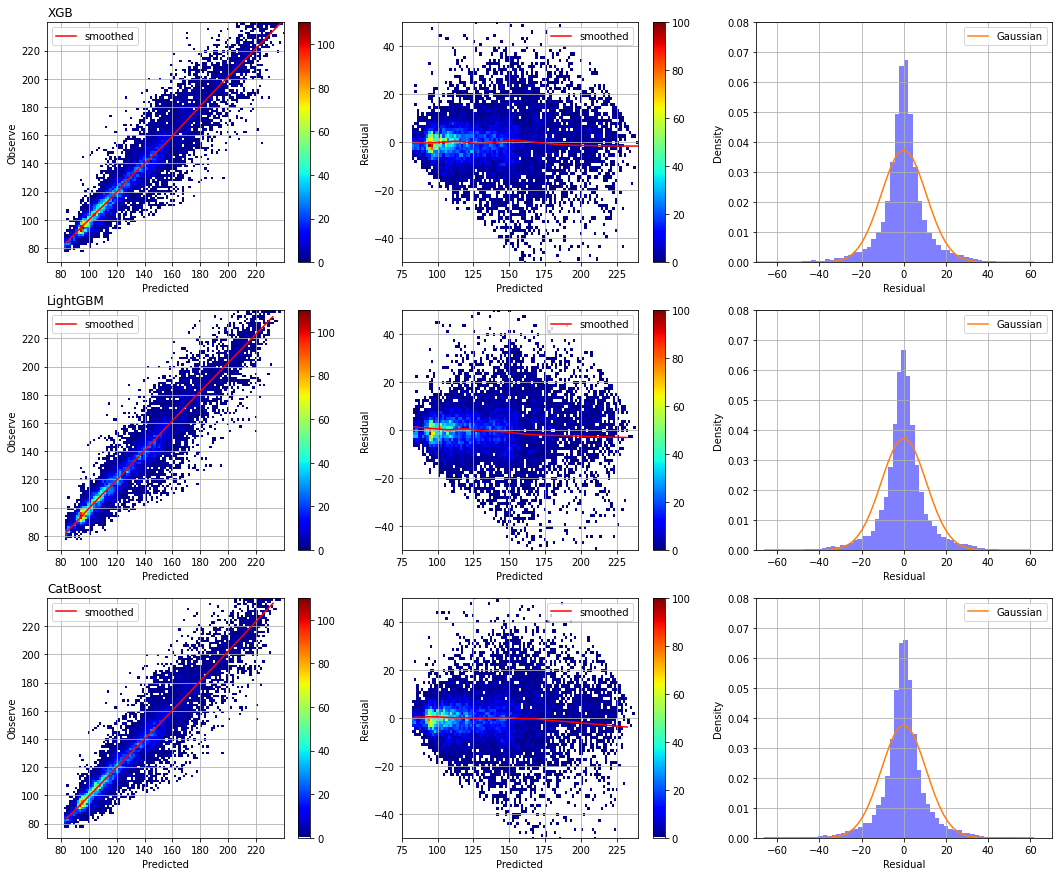

In [59]:
fig, ax = plt.subplots(3,3,figsize=(18,15))

for i in range(len(titles)):
  pred_sort, obser_sm, resid_sm = lowess_sm(obser, preds[i], 1000)
  plot_resid_pred(preds[i], obser, resids[i], pred_sort, obser_sm, resid_sm, fig, ax[i,:], titles[i])


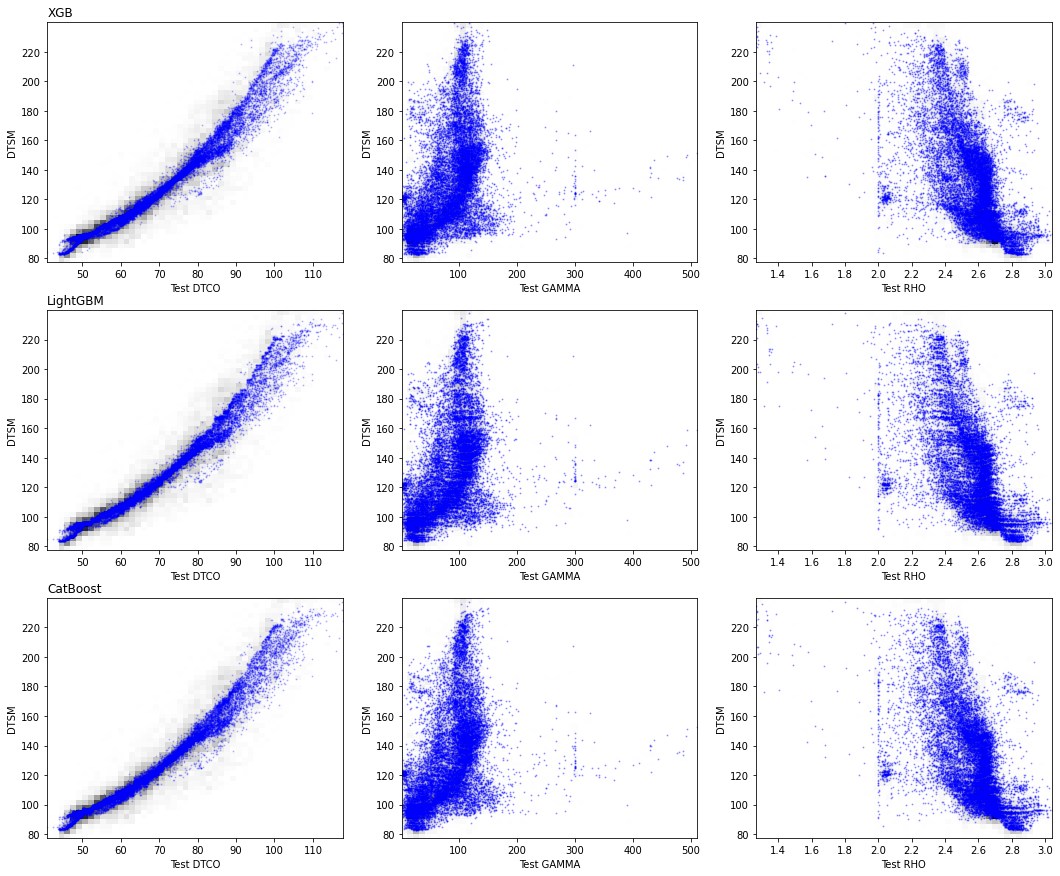

In [53]:
fig, ax = plt.subplots(3,3,figsize=(18,15))

for i in range(len(titles)):
  plot_pred_feature(X_test, Y_test, preds[i], fig, ax[i,:], titles[i])


## Reference

https://github.com/fmfn/BayesianOptimization

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training

https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst

https://catboost.ai/docs/concepts/python-reference_cv.html

https://github.com/dc-aichara/DS-ML-Public/blob/master/Medium_Files/hyp_tune.ipynb




